# VQA datasets preprocessing and exploration

In this notebook we're exploring and preprocessing the following VQA datasets: VQA, DAQUAR and Visual Genome.

We'll explore them, unify them to a single schema and write the unified dataframe locally for further explotation. 

## Imports

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")

spark = SparkSession \
    .builder \
    .appName("QuestionRephrasing-DataExploration") \
    .config("spark.executor.memory", "5G")\
    .config("spark.driver.memory", "10G")\
    .config("spark.driver.maxResultSize", "5G")\
    .getOrCreate()

spark.sparkContext.setCheckpointDir('data/checkpoints')

def plot_question_statistics(df):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].hist(df["question_len"].to_list(), bins=25)
    axs[0].set_title('Question length distribution (chars)')
    axs[1].hist(df["question_word_len"].to_list(), bins=25)
    axs[1].set_title('Question length distribution (words)')
    df['first_word'].value_counts().nlargest(25).plot(kind='bar', title='Question first word distribution', ax=axs[2])
    df['answer'].value_counts().nlargest(25).plot(kind='bar', title='Answers distribution', ax=axs[3])

question_tokenize = F.udf(lambda x: word_tokenize(x), ArrayType(StringType()))

@F.udf
def lower_string(string):
    return string.lower()

@F.udf
def remove_dot_characters(string):
    return string.replace(".", "")

@F.udf
def first_element(array):
    return array[0]

@F.udf
def question_len(question):
    return len(question)

## Dataset loading (VQA, DAQUAR and Visual Genome)

Entry example:
 [Row(question='what is on the right side of the black telephone and on the left side of the red chair ?', answer='desk', image_id='image3', tokenized_question=['what', 'is', 'on', 'the', 'right', 'side', 'of', 'the', 'black', 'telephone', 'and', 'on', 'the', 'left', 'side', 'of', 'the', 'red', 'chair', '?'], question_len=88.0, question_word_len=20.0, first_word='what')]


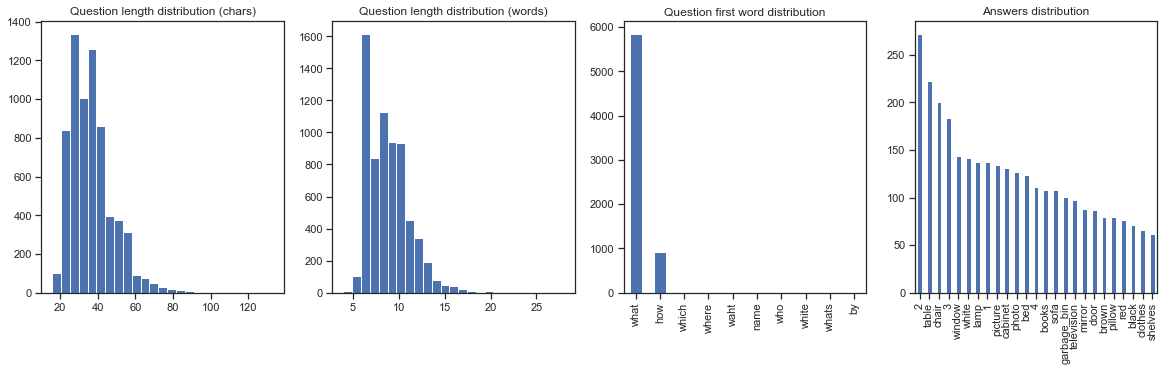

In [2]:
# Load the DAQUAR dataset
daquar_train = spark.read.csv("data/daquar/qa.894.raw.train.format_triple_processed.txt", header=True, sep="|")\
    .withColumnRenamed("Question", "question")\
    .withColumnRenamed("Answer", "answer")\
    .withColumnRenamed("Image", "image_id")\
    .withColumn("tokenized_question", question_tokenize(F.col("question")))\
    .withColumn("question_len", question_len(F.col("question")))\
    .withColumn("question_word_len", F.size((F.col("tokenized_question"))))\
    .withColumn("question_word_len", F.col("question_word_len").cast(DoubleType()))\
    .withColumn("question_len", F.col("question_len").cast(DoubleType()))\
    .withColumn("first_word", first_element(F.col("tokenized_question")))\
    .withColumn("answer", lower_string(F.col('answer')))\
    .withColumn("answer", remove_dot_characters(F.col('answer')))

print(f"Entry example:\n {daquar_train.head(1)}")
plot_question_statistics(daquar_train.toPandas())

Entry example:
 [Row(question='what is this photo taken looking through?', answer='net', image_id='458752', tokenized_question=['what', 'is', 'this', 'photo', 'taken', 'looking', 'through', '?'], question_len=41.0, question_word_len=8.0, first_word='what')]


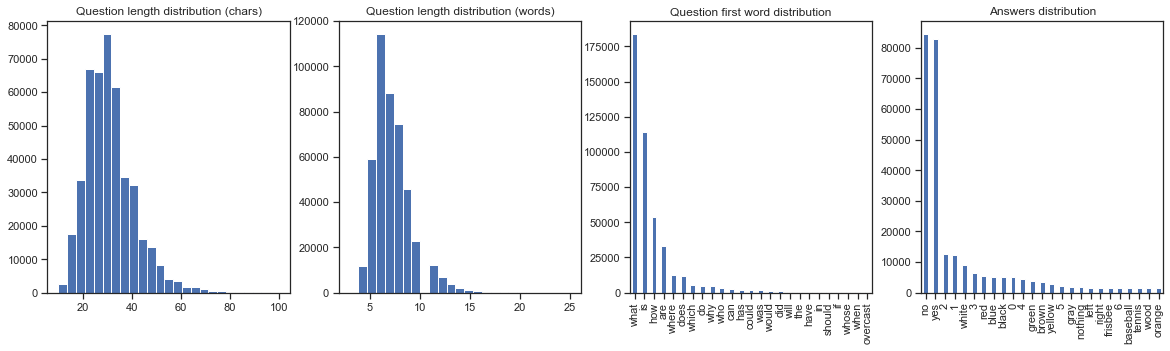

In [3]:
# Load the VQA dataset

# load questions
vqa_train_questions = spark.read.json("data/vqa/v2_OpenEnded_mscoco_train2014_questions.json").select("questions")\
    .select(F.explode("questions"))\
    .select("col.*")

@F.udf
def mode(x):
    from collections import Counter
    return Counter([answer['answer'] for answer in x]).most_common(1)[0][0]

# load answers
vqa_train_answers = spark.read.json("data/vqa/v2_mscoco_train2014_annotations.json").select(F.explode("annotations"))\
    .select("col.*")\
    .withColumn("mode_answer", mode("answers"))\
    .withColumn("answer_id", F.col("answers.answer_id"))\
    .drop("answers", "answer_type", "answers", "multiple_choice_answer", "question_type", "image_id", "answer_id")

# join answers and questions
vqa_train = vqa_train_questions.join(vqa_train_answers, on=["question_id"], how='inner')\
    .withColumn("question_id", F.col("question_id").cast(StringType()))\
    .withColumn("image_id", F.col("image_id").cast(StringType()))\
    .withColumnRenamed("mode_answer", "answer")\
    .drop("question_id")\
    .withColumn("question", lower_string(F.col("question")))\
    .withColumn("tokenized_question", question_tokenize(F.col("question")))\
    .withColumn("question_len", question_len(F.col("question")))\
    .withColumn("question_word_len", F.size(F.col("tokenized_question")))\
    .withColumn("question_word_len", F.col("question_word_len").cast(DoubleType()))\
    .withColumn("question_len", F.col("question_len").cast(DoubleType()))\
    .withColumn("first_word", first_element(F.col("tokenized_question")))\
    .select('question', 'answer', 'image_id', 'tokenized_question', 'question_len', 'question_word_len', 'first_word')\
    .withColumn("answer", lower_string(F.col('answer')))\
    .withColumn("answer", remove_dot_characters(F.col('answer')))

print(f"Entry example:\n {vqa_train.head(1)}")
plot_question_statistics(vqa_train.toPandas())

Entry example:
 [Row(question='what color is the clock?', answer='green', image_id='1', tokenized_question=['what', 'color', 'is', 'the', 'clock', '?'], question_len=24.0, question_word_len=6.0, first_word='what')]


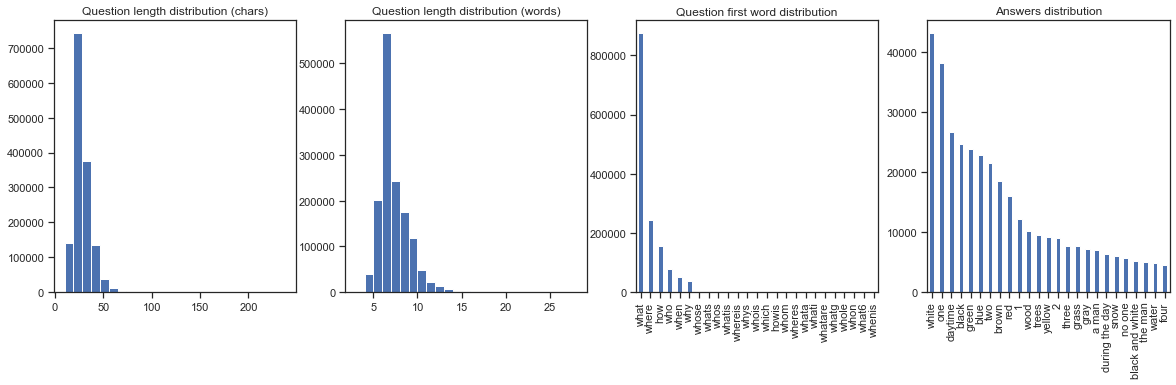

In [4]:
# Load Visual Genome dataset
visual_genome_train = spark.read.json("data/visual-genome/question_answers.json")\
    .select(F.explode("qas"))\
    .select("col.*")\
    .withColumn("image_id", F.col("image_id").cast(StringType()))\
    .drop("a_objects", "q_objects", "qa_id")\
    .withColumn("question", lower_string(F.col("question")))\
    .withColumn("tokenized_question", question_tokenize(F.col("question")))\
    .withColumn("question_len", question_len(F.col("question")))\
    .withColumn("question_word_len", F.size(F.col("tokenized_question")))\
    .withColumn("question_word_len", F.col("question_word_len").cast(DoubleType()))\
    .withColumn("question_len", F.col("question_len").cast(DoubleType()))\
    .withColumn("first_word", first_element(F.col("tokenized_question")))\
    .select('question', 'answer', 'image_id', 'tokenized_question', 'question_len', 'question_word_len', 'first_word')\
    .withColumn("answer", lower_string(F.col('answer')))\
    .withColumn("answer", remove_dot_characters(F.col('answer')))    

print(f"Entry example:\n {visual_genome_train.head(1)}")
plot_question_statistics(visual_genome_train.toPandas())

## Union the datasets, plot statistics and save them as parquets

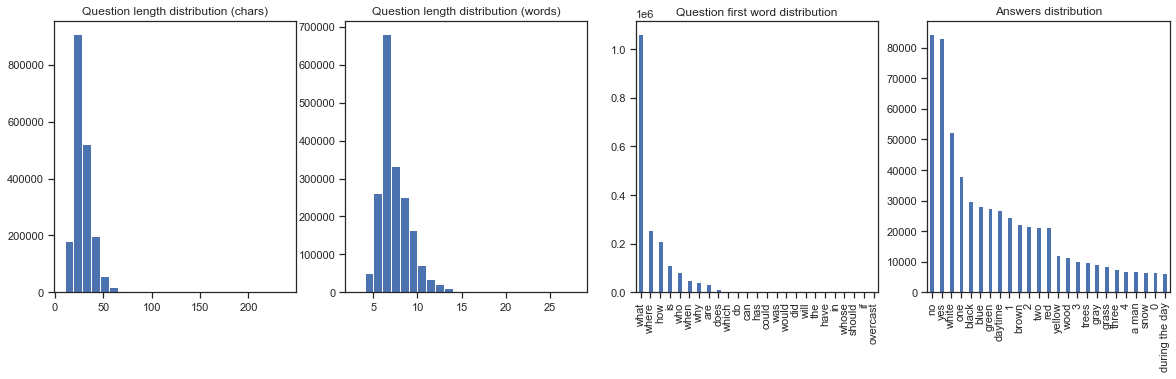

In [5]:
union_train = daquar_train.union(vqa_train).union(visual_genome_train)
plot_question_statistics(union_train.toPandas())

In [6]:
# write all the datasets as parquets
daquar_train.write.mode('overwrite').parquet("data/processed/daquar")
vqa_train.write.mode('overwrite').parquet("data/processed/vqa")
visual_genome_train.write.mode('overwrite').parquet("data/processed/visual_genome")
union_train.write.mode('overwrite').parquet("data/processed/union")